In [1]:
import torch
from dlc_practical_prologue import generate_pair_sets
import torch.nn as nn
from print_util import *
import time

## 1. Generate raw data, process it

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
def generate_data_device(n, device='cpu'):
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(n)
    train_input = train_input.to(device=device)
    train_target = train_target.to(device=device)
    train_classes = train_classes.to(device=device)
    test_input = test_input.to(device=device)
    test_target = test_target.to(device=device)
    test_classes = test_classes.to(device=device)
    return train_input, train_target, train_classes, test_input, test_target, test_classes

In [4]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)

In [5]:
def normalize_data(tensor):
    mu, std = tensor.mean(), tensor.std()
    tmp = tensor.sub(mu).div(std)
    return tmp

In [6]:
def convert_to_one_hot_labels(target):
    tmp = target.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

_We normalized the data so it has mean 0 and std 1._

In [7]:
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

In [8]:
print("Training set mean = {a}".format(a = train_input.mean().item()))
print("Training set std = {s}\n".format(s = train_input.std().item()))
print("Test set mean = {a}".format(a = test_input.mean().item()))
print("Test set std = {s}".format(s = test_input.std().item()))

Training set mean = 7.753956055012168e-08
Training set std = 1.0

Test set mean = -3.269740478373251e-09
Test set std = 1.0


_We will create a validation set to tune hyperparameters. This validation set is created from the training set in order to have fully independent testing data._

_80% of the training data goes to training and the remaining 20% for our validation set._

In [9]:
index_permutation = torch.randperm(train_input.size(0))

validation_proportion = 0.2
split = int(0.2 * train_input.size(0))

validation_index = index_permutation[:split]
training_index = index_permutation[split:]

validation_input = train_input[validation_index]
validation_target = train_target[validation_index]
validation_classes = train_classes[validation_index]

train_input = train_input[training_index]
train_target = train_target[training_index]
train_classes = train_classes[training_index]

In [10]:
print(train_input.size(0))
print(validation_input.size(0))

800
200


In [11]:
print(train_input[:, 0:1, :, :].shape)

torch.Size([800, 1, 14, 14])


## 2. Creating & Training models

In [12]:
import models
import torch.nn.functional as F

In [13]:
BATCH_SIZE = 64
architecture = models.SiameseNetwork2

In [14]:
def test(test_input, test_target, test_classes, model, criterion, batch_size):
    model.eval()  # Switch to eval mode in case we use an architecture that requires it
    with torch.no_grad():
        nb_data_errors = 0
        loss_sum = 0
        
        for inputs, targets in zip(test_input.split(batch_size),
                                  test_target.split(batch_size)):
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_sum += loss
            _, predicted_classes = torch.max(outputs, 1)
            
            for k in range(len(inputs)):
                if targets[k] != predicted_classes[k]:
                    nb_data_errors = nb_data_errors + 1

        accuracy = (1 - (nb_data_errors / test_input.size(0))) * 100
        
        return accuracy, loss_sum.item()

In [15]:
def train_model(model, train_input, train_target, train_classes, test_input, test_target, test_classes,
                nb_epoch, batch_size, optimizer_params, logging = False, aux=0.0):
    nb_epoch, batch_size = nb_epoch, batch_size
    lr, momentum, weight_decay, gamma = optimizer_params['lr'], optimizer_params['momentum'], optimizer_params['weight_decay'], optimizer_params['gamma']    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    criterion = nn.CrossEntropyLoss()
    
    if logging:
        log_acc_loss_header(color=Color.GREEN)
    
        train_accuracies = []
        train_losses = []
        test_accuracies = []
        test_losses = []
        start_time = time.time()
    
    for e in range(nb_epoch):
        model.train()  # Switch to train mode in case we use an architecture that requires it
        for inputs, targets, classes in zip(train_input.split(batch_size),
                                            train_target.split(batch_size),
                                            train_classes.split(batch_size)):
            
            if aux != 0.0:
                inputs1 = inputs[:, 0:1, :, :]
                inputs2 = inputs[:, 1:2, :, :]
                outputs1 = model.digit_pred(inputs1)
                outputs2 = model.digit_pred(inputs2)
                loss1 = criterion(outputs1, classes[:, 0])
                loss2 = criterion(outputs2, classes[:, 1])
                loss = aux * (loss1 + loss2)
            else:
                loss = 0
                
            outputs = model(inputs)
            loss += criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()  # Update the learning rate
        
        if logging:
            train_acc, train_loss = test(train_input, train_target, train_classes, model, criterion, batch_size)
            test_acc, test_loss = test(test_input, test_target, test_classes, model, criterion, batch_size)
        
            train_accuracies.append(train_acc)
            train_losses.append(train_loss)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)
        
            elapsed_time = time.time() - start_time
            log_acc_loss(e, nb_epoch, elapsed_time, train_loss, train_acc, test_loss, test_acc, persistent=False)
            
    if logging:
        print()
        return train_accuracies, train_losses, test_accuracies, test_losses

_Testing if the training is done correctly._

In [16]:
basic_model = architecture()
basic_model = basic_model.to(device=device)

train_accuracies, train_losses, test_accuracies, test_losses = train_model(basic_model,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           20, 
                                                                           BATCH_SIZE, 
                                                                           {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.8}, 
                                                                           logging = True,
                                                                          aux = 0.5)

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[20/20]     31s     0.2093         99.7500             7.3055         91.1000             


_We will now tune hyperparameters. For now, we are tuning the learning rate, the momemtum and the number of epochs._

In [17]:
run_cell = False
if run_cell:
    learning_rates = [0.001, 0.01, 0.1, 0.25, 0.5]
    momentums = [0.9] #[0.5, 0.7, 0.9]
    weight_decays = [0.0] #, 0.01, 0.1]
    nb_epoch = 50
    gammas = [0.8, 0.9, 1.0]
    auxs = [0.0, 0.1, 0.2, 0.4]

    best_accuracy = 0
    best_params = {}

    for lr in learning_rates:
        for gamma in gammas:
            for momentum in momentums:
                for weight_decay in weight_decays:

                    # creating params for optimizer
                    optimizer_params = {'lr':lr, 'momentum':momentum, 'weight_decay': weight_decay, 'gamma': gamma}

                    # initialize raw model
                    model = architecture()
                    model = model.to(device=device)

                    # train model on training data
                    train_model(model,
                                train_input,
                                train_target,
                                train_classes,
                                None,
                                None,
                                None,
                                nb_epoch, BATCH_SIZE, optimizer_params)

                    # compute accuracy on validation data
                    accuracy, loss = test(validation_input, validation_target, validation_classes, model, nn.CrossEntropyLoss(), BATCH_SIZE)

                    print("Lr: " + repr(lr) + " - Momentum: " + repr(momentum) + " - Weight decay: " + repr(weight_decay) +
                         " - Gamma: " + repr(gamma) + " => Accuracy: " + repr(accuracy))

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params['lr'] = lr
                        best_params['momentum'] = momentum
                        best_params['nb_epoch'] = nb_epoch
                        best_params['weight_decay'] = weight_decay
                        best_params['gamma'] = gamma

    print("Best accuracy obtained = {a}\n".format(a = best_accuracy))
    print("with the following hyperparameters:\n")
    print(best_params)

## NOTE: Hyperparameters tuning is not optimal yet, do not consider the above results as  good yet.

In [18]:
best_optimizer_params = {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0, 'gamma': 0.97}
best_nb_epoch = 50

_Now that we have the best hyperparameters let's retrained the model and visualize the evolution of accuracy and loss on both the train and test sets._

In [42]:
final_model = architecture().to(device=device)
# We regenerate data to train the model on all the training data available. 
# We don't need the validation split at this step.
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

In [43]:
train_accuracies, train_losses, test_accuracies, test_losses = train_model(final_model,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           best_nb_epoch, 
                                                                           BATCH_SIZE, 
                                                                           best_optimizer_params, 
                                                                           logging = True,
                                                                           aux=0.2)

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[50/50]     150s    0.0021         100.0000            13.4644        91.1000             


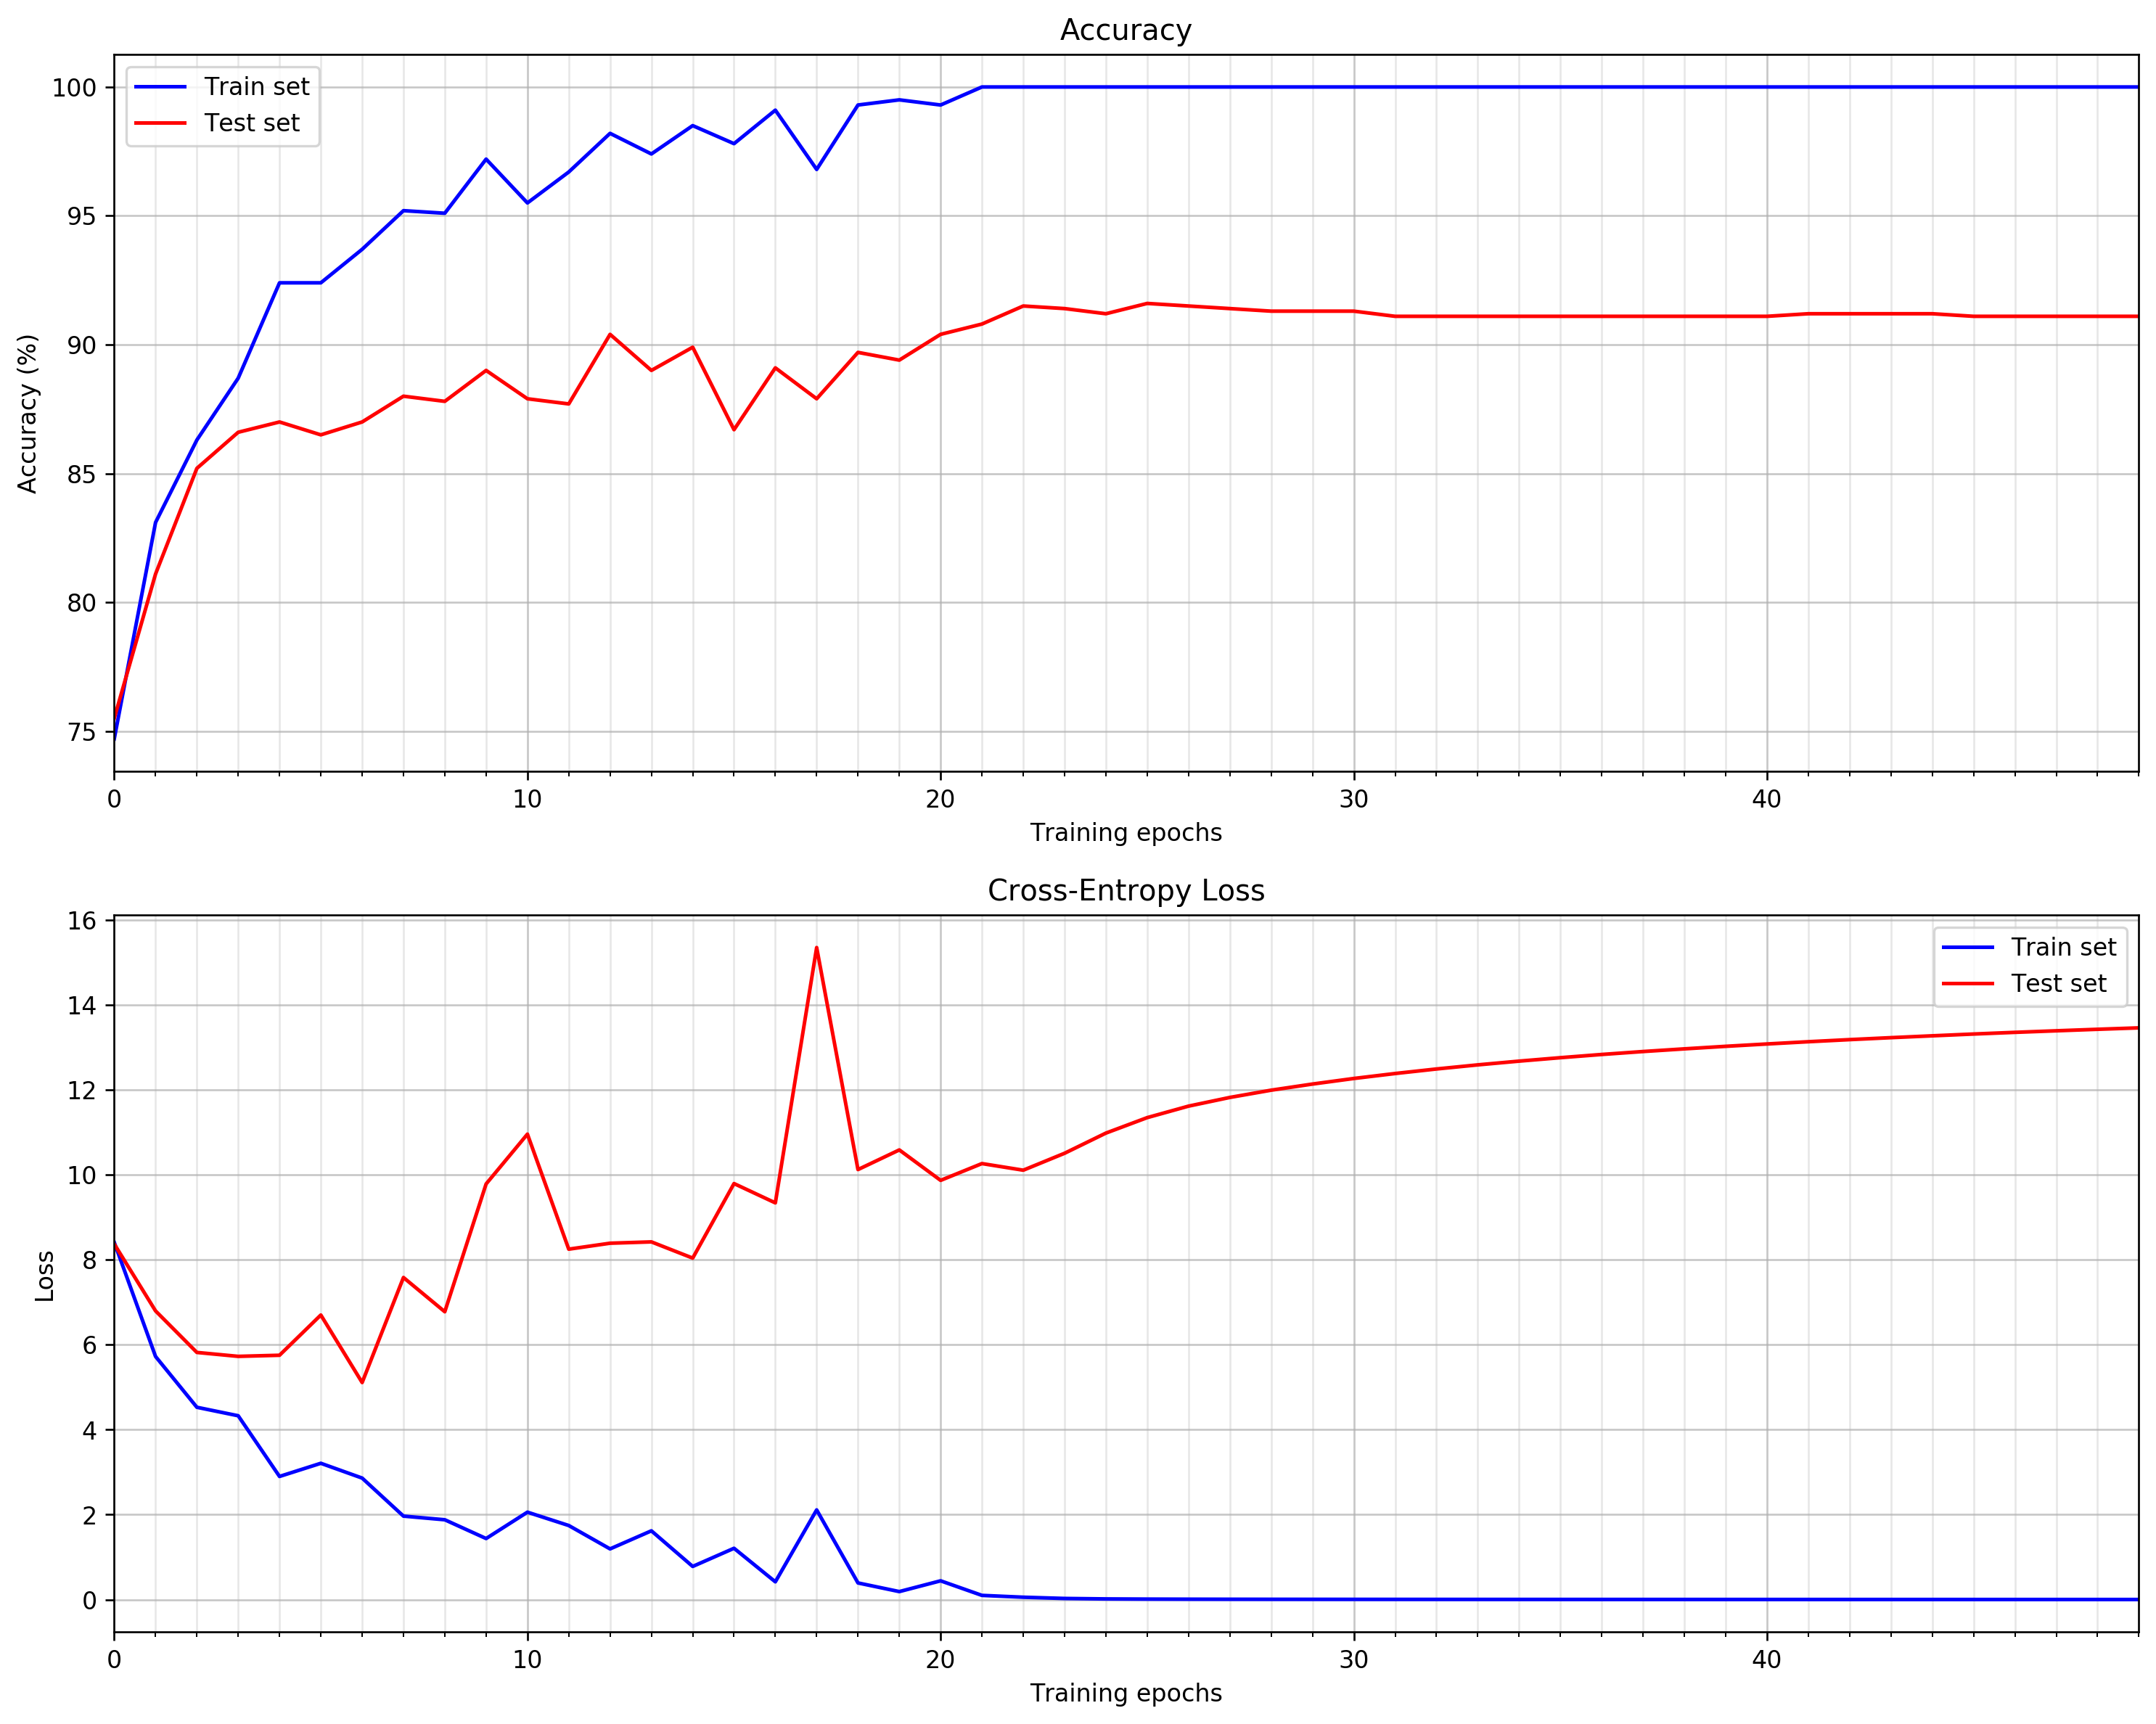

In [44]:
plot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses)

## 3. Testing model

_In order to test the model we will generate new data (training and test set), retrained the model on the new data en evaluate it on the new test set. We will do this process more than 10 times and estimates the mean accuracy as well as its standard deviation._

In [22]:
nb_rounds = 10

In [45]:
def evaluate_model(model, nb_rounds, criterion):
    
    accuracies = []
    
    for round in range(nb_rounds):
        
        # initialize new model
        model_evaluated = model().to(device=device)
        # generate new data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)
        train_input = normalize_data(train_input)
        test_input = normalize_data(test_input)
        
        train_model(model_evaluated,
                    train_input,
                    train_target,
                    train_classes,
                    None,
                    None,
                    None,
                    best_nb_epoch, BATCH_SIZE, best_optimizer_params,
                   aux = 0.2)
        
        accuracy, loss = test(test_input, test_target, test_classes, model_evaluated, criterion, BATCH_SIZE)
        
        print("Round {i}: accuracy = {a:0.2f}% | loss = {l:0.4f}".format(i = (round + 1), a = accuracy, l = loss))
        
        accuracies.append(accuracy)
        
    return torch.FloatTensor(accuracies)

In [46]:
accuracies = evaluate_model(architecture, nb_rounds, nn.CrossEntropyLoss())

Round 1: accuracy = 91.20% | loss = 16.2452
Round 2: accuracy = 91.40% | loss = 12.0968
Round 3: accuracy = 89.90% | loss = 15.1191
Round 4: accuracy = 90.50% | loss = 14.2515
Round 5: accuracy = 90.80% | loss = 12.8808
Round 6: accuracy = 90.00% | loss = 13.8611
Round 7: accuracy = 90.60% | loss = 15.4707
Round 8: accuracy = 90.90% | loss = 16.9051
Round 9: accuracy = 89.20% | loss = 16.5591
Round 10: accuracy = 91.20% | loss = 16.8150


In [47]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies.mean()))
print("The accuracy std is: {s:0.4f}".format(s = accuracies.std()))

The mean accuracy is: 90.57
The accuracy std is: 0.6913
